In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

# Инициализация модели

In [2]:
from blocksnet.models import City

In [3]:
city_model = City.from_pickle('data/spb/city.pickle')

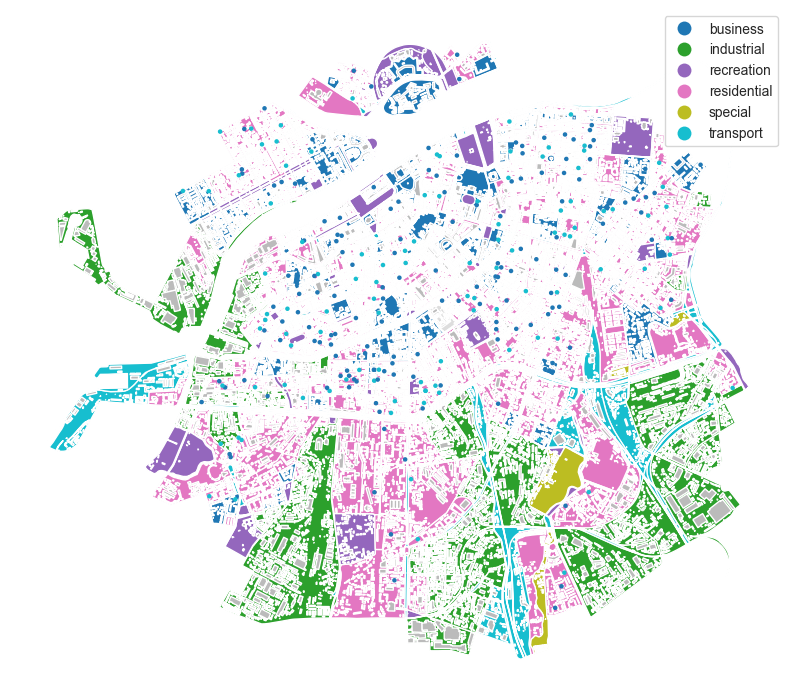

In [4]:
city_model.plot()

In [5]:
pd.DataFrame(city_model.service_types)

,0,1,2,3,4,5
0,"(code, 3.5.1)","(name, school)","(accessibility, 15)","(demand, 120)","(land_use, [LandUse.RESIDENTIAL, LandUse.BUSIN...","(bricks, [capacity=250 area=3200.0 is_integrat..."
1,"(code, 3.5.1)","(name, kindergarten)","(accessibility, 7)","(demand, 61)","(land_use, [LandUse.RESIDENTIAL, LandUse.BUSIN...","(bricks, [capacity=80 area=230.0 is_integrated..."
2,"(code, 3.4.2)","(name, hospital)","(accessibility, 60)","(demand, 9)","(land_use, [LandUse.RESIDENTIAL, LandUse.BUSIN...","(bricks, [capacity=110 area=3500.0 is_integrat..."
3,"(code, 3.4.1)","(name, polyclinic)","(accessibility, 10)","(demand, 13)","(land_use, [LandUse.RESIDENTIAL, LandUse.BUSIN...","(bricks, [capacity=100 area=850.0 is_integrate..."
4,"(code, 5.1.3)","(name, pitch)","(accessibility, 60)","(demand, 10)","(land_use, [LandUse.RESIDENTIAL, LandUse.BUSIN...","(bricks, [capacity=10 area=150.0 is_integrated..."
...,...,...,...,...,...,...
61,"(code, 8.4)","(name, prison)","(accessibility, 90)","(demand, 2)","(land_use, [LandUse.SPECIAL])","(bricks, [capacity=1600 area=3000.0 is_integra..."
62,"(code, 12.2)","(name, landfill)","(accessibility, 90)","(demand, 1)","(land_use, [LandUse.SPECIAL, LandUse.TRANSPORT])","(bricks, [capacity=500 area=400.0 is_integrate..."
63,"(code, 1.17)","(name, plant_nursery)","(accessibility, 60)","(demand, 1)","(land_use, [LandUse.AGRICULTURE])","(bricks, [capacity=30 area=200.0 is_integrated..."
64,"(code, 1.3)","(name, greenhouse_complex)","(accessibility, 90)","(demand, 1)","(land_use, [LandUse.AGRICULTURE])","(bricks, [capacity=180 area=2000.0 is_integrat..."


# Оценка обеспеченности

In [6]:
from blocksnet.method.provision.provision import Provision, ProvisionMethod

In [7]:
prov = Provision(city_model=city_model)

In [8]:
service_type = city_model['school']; service_type

ServiceType(code='3.5.1', name='school', accessibility=15, demand=120, land_use=[<LandUse.RESIDENTIAL: 'residential'>, <LandUse.BUSINESS: 'business'>], bricks=[ServiceBrick(capacity=250, area=3200.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=300, area=4000.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=600, area=8200.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=1100, area=13000.0, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=250, area=2200.0, is_integrated=True, parking_area=200.0), ServiceBrick(capacity=300, area=3600.0, is_integrated=True, parking_area=300.0), ServiceBrick(capacity=600, area=7100.0, is_integrated=True, parking_area=600.0)])

In [9]:
calc_before = prov.calculate(service_type, method=ProvisionMethod.GRAVITATIONAL, self_supply=True)
prov.plot(calc_before)

['/home/ddddanil/IT/Progs/urban_2024/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc', '/tmp/255f7625dae3439d923b4bb79bef7a7d-pulp.mps', 'max', 'timeMode', 'elapsed', 'branch', 'printingOptions', 'all', 'solution', '/tmp/255f7625dae3439d923b4bb79bef7a7d-pulp.sol']
-11
b''


PulpSolverError: Pulp: Error while trying to execute, use msg=True for more details/home/ddddanil/IT/Progs/urban_2024/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc

In [ ]:
total = prov.total_provision(calc_before)
bounds = prov.get_bounds(service_type)
print(f'{bounds[0]} -> {total} -> {bounds[1]}')

## Обновление обеспеченности

In [ ]:
blocks_gdf = city_model.get_blocks_gdf(True)
blocks_gdf.explore()

In [ ]:
update = {
  135: {
    'population': 100000,
  }
}

update_df = pd.DataFrame.from_dict(update, orient='index')

In [ ]:
calc_after = prov.calculate(service_type, update_df=update_df, method=ProvisionMethod.GRAVITATIONAL, self_supply=True)
prov.plot(calc_after)

In [ ]:
prov.plot_delta(calc_before, calc_after, figsize=(10,10))

In [ ]:
Provision.stat_provision(calc_before)

In [ ]:
Provision.stat_provision(calc_after)

In [ ]:
scenario = {'school': 0.5, 'kindergarten': 0.5}
gdf, total = prov.calculate_scenario(scenario, self_supply=True)
print(total)

In [ ]:
prov.plot_provisions(gdf, (15,10))

# Свободная площадь

In [ ]:
from blocksnet.method.vacant_area import VacantArea
import contextily as cx

In [ ]:
block = city_model[416]
vacant_areas = VacantArea(city_model=city_model).calculate([block])
vacant_areas.head()

In [ ]:
ax = vacant_areas.plot(figsize=(5,5))
block.get_buildings_gdf().plot(ax=ax, color='#666')
services_gdf = block.get_services_gdf()
services_gdf.loc[services_gdf.geom_type.isin(['Polygon', 'MultiPolygon'])].plot(ax=ax, color='#ddd')
ax.set_axis_off()

In [ ]:
vacant_areas.explore()